<p style="background-color:#FFFFFF;color:blue;font-size:24px;text-align:center;border-radius:05px 05px;font-weight:bold;border:2px;padding: 10px;">EDA - CatBoost - RF </p>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score

## Read csv files

In [2]:
df_train = pd.read_csv('../input/home-loan-approval/loan_sanction_train.csv', index_col = 'Loan_ID')
df_test = pd.read_csv('../input/home-loan-approval/loan_sanction_train.csv', index_col = 'Loan_ID')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, LP001002 to LP002990
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 62.4+ KB


In [4]:
df_test.shape

(614, 12)

In [5]:
df_train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [6]:
df_train = df_train.rename_axis(None, axis=0) 
df_test = df_train.rename_axis(None, axis=0) 

In [7]:
df_train.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [8]:
df_train['Gender'].value_counts()

Male      489
Female    112
Name: Gender, dtype: int64

Text(0, 0.5, 'value counts')

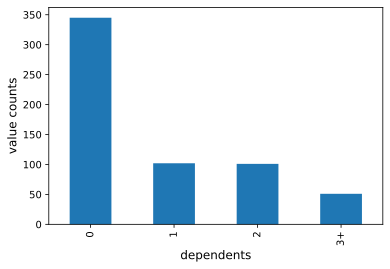

In [9]:
df_train['Dependents'].value_counts().plot.bar()
plt.xlabel('dependents',fontsize = 12)
plt.ylabel('value counts',fontsize = 12)

<AxesSubplot:xlabel='Married', ylabel='count'>

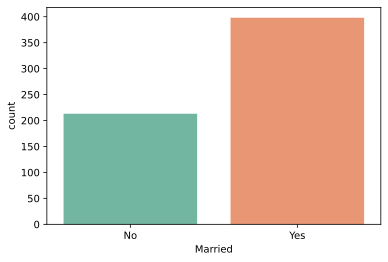

In [10]:
sns.countplot(df_train['Married'], palette='Set2')

<AxesSubplot:xlabel='Self_Employed', ylabel='count'>

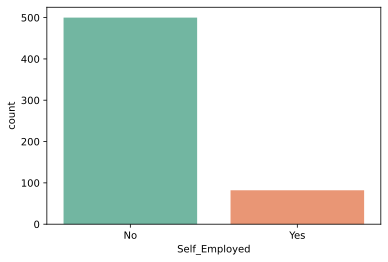

In [11]:
sns.countplot(df_train['Self_Employed'], palette='Set2')

Text(0, 0.5, 'value counts')

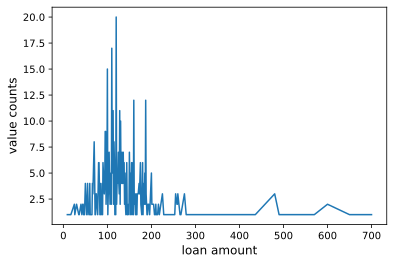

In [12]:
df_train['LoanAmount'].value_counts().sort_index().plot()
plt.xlabel('loan amount',fontsize = 12)
plt.ylabel('value counts',fontsize = 12)

Text(0, 0.5, 'value counts')

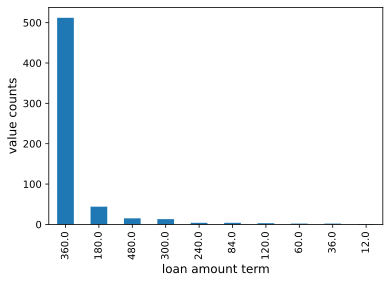

In [13]:
df_train['Loan_Amount_Term'].value_counts().plot.bar()
plt.xlabel('loan amount term',fontsize = 12)
plt.ylabel('value counts',fontsize = 12)

In [14]:
df_train['Credit_History'].value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

<AxesSubplot:xlabel='Property_Area', ylabel='count'>

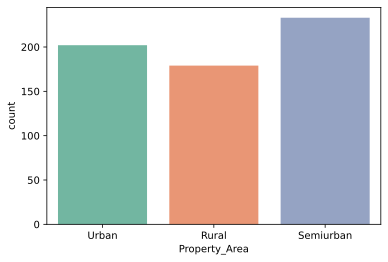

In [15]:
sns.countplot(df_train['Property_Area'], palette='Set2')

## Replaced the null values

In [16]:
for col in df_train:
    df_train[col] = df_train[col].fillna(df_train[col].value_counts().idxmax())

In [17]:
df_train.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

## Preprocessing of categorical features

In [18]:
le = LabelEncoder()
cat_features = ['Gender', 'Married', 'Education', 'Self_Employed', 'Loan_Status']
for col in df_train[cat_features]:
    le.fit(df_train[col])
    df_train[col] = le.transform(df_train[col])

In [19]:
df_train = pd.get_dummies(df_train, columns = ['Property_Area'])

In [20]:
df_train['Dependents'] = df_train['Dependents'].replace('3+', 3).astype('int')

In [21]:
df_train['Dependents'].value_counts()

0    360
1    102
2    101
3     51
Name: Dependents, dtype: int64

In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, LP001002 to LP002990
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   614 non-null    int64  
 1   Married                  614 non-null    int64  
 2   Dependents               614 non-null    int64  
 3   Education                614 non-null    int64  
 4   Self_Employed            614 non-null    int64  
 5   ApplicantIncome          614 non-null    int64  
 6   CoapplicantIncome        614 non-null    float64
 7   LoanAmount               614 non-null    float64
 8   Loan_Amount_Term         614 non-null    float64
 9   Credit_History           614 non-null    float64
 10  Loan_Status              614 non-null    int64  
 11  Property_Area_Rural      614 non-null    uint8  
 12  Property_Area_Semiurban  614 non-null    uint8  
 13  Property_Area_Urban      614 non-null    uint8  
dtypes: float64(4), int6

In [23]:
df_train.tail()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
LP002978,0,0,0,0,0,2900,0.0,71.0,360.0,1.0,1,1,0,0
LP002979,1,1,3,0,0,4106,0.0,40.0,180.0,1.0,1,1,0,0
LP002983,1,1,1,0,0,8072,240.0,253.0,360.0,1.0,1,0,0,1
LP002984,1,1,2,0,0,7583,0.0,187.0,360.0,1.0,1,0,0,1
LP002990,0,0,0,0,1,4583,0.0,133.0,360.0,0.0,0,0,1,0


## Train test split

In [24]:
y = df_train['Loan_Status']
df_train = df_train.drop(['Loan_Status'], axis=1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df_train, y, 
                                                    test_size = 0.3, 
                                                    random_state = 123)

In [26]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((429, 13), (429,), (185, 13), (185,))

<p style="background-color:#008000;color:white;font-size:24px;text-align:center;border-radius:05px 05px;font-weight:bold;border:2px;padding: 10px;">Random Forest</p>

In [27]:
rfc = RandomForestClassifier(n_estimators = 250, random_state = 123)

rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=250, random_state=123)

In [28]:
y_pred = rfc.predict(X_test)

## accuracy_score | f1_score

In [29]:
accuracy_score(y_pred, y_test)

0.7567567567567568

In [30]:
confusion_matrix(y_pred,y_test)

array([[ 26,   7],
       [ 38, 114]])

In [31]:
f1_score(y_pred,y_test)

0.8351648351648352

<p style="background-color:#ffa500;color:white;font-size:24px;text-align:center;border-radius:05px 05px;font-weight:bold;border:2px;padding: 10px;">CatBoost</p>

In [32]:
cbc = CatBoostClassifier(
    iterations = 500, 
    learning_rate = 0.01, 
    random_state = 123,
    custom_loss=['AUC', 'Accuracy'])

cbc.fit(X_train, y_train, 
        verbose = False)

In [33]:
y_pred_1 = cbc.predict(X_test)

## accuracy_score | f1_score

In [34]:
accuracy_score(y_pred_1, y_test)

0.7783783783783784

In [35]:
f1_score(y_pred_1 ,y_test)

0.851985559566787

In [36]:
from sklearn.linear_model import LinearRegression

In [37]:
lrg= LinearRegression()

In [39]:
lrg.fit(X_train,y_train)

LinearRegression()

In [76]:
y_pred=lrg.predict(X_test)
y_pred

array([ 0.83463829,  0.81946014,  0.76941728,  0.7309681 ,  0.08523649,
        0.89976312,  0.9032106 ,  0.7669495 ,  0.71392508,  0.80716679,
        0.11807698,  0.89118957,  0.77554825,  0.90276844,  0.90004258,
        0.75535572,  0.17552089,  0.74752946,  0.83771323,  0.09722856,
        0.7643525 ,  0.81508324,  0.74926816,  0.8300367 ,  0.8670608 ,
        0.82551528,  0.82355764,  0.82941247,  0.70464778,  0.15242252,
        0.84168603,  0.09120274,  0.09104261,  0.70250521,  0.72239286,
        0.73678795,  0.06885954,  0.72167342,  0.88086047,  0.79344891,
        0.79172229,  0.82587729,  0.89958843,  0.91203038,  0.79251747,
        0.74557973,  0.00102786,  0.81550443,  0.84475913,  0.67800889,
        0.1036386 ,  0.83635342,  0.70922949,  0.82676138, -0.03311508,
        0.80286457,  0.82479248,  0.75530912,  0.72891551,  0.81648261,
        0.77486811,  0.04507434,  0.79421102,  0.89550174,  0.87215216,
        0.82330198,  0.73709257,  0.81927824, -0.09182939,  0.76

In [77]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(y_test,y_pred)

In [78]:
mse

0.16712048138901578

In [79]:
lrg.predict([[0,1,0,1,0,1500,0.0,60.0,430.0,1.0,0,1,0]])

array([0.88440058])

In [82]:
from sklearn.metrics import accuracy_score as acc1

In [87]:
acc=acc1(y_pred_1,y_test)

In [88]:
acc

0.7783783783783784

In [89]:
clf_re=classification_report(y_test,y_pred_1)

In [90]:
print(clf_re)

              precision    recall  f1-score   support

           0       0.90      0.41      0.56        64
           1       0.76      0.98      0.85       121

    accuracy                           0.78       185
   macro avg       0.83      0.69      0.71       185
weighted avg       0.80      0.78      0.75       185



compare the the three models randomforest , catbooster , linearRegression models the catbooster has a high accuracy than the other two models. 